In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
import importlib
import structures
importlib.reload(structures)
from structures import *
#import losses
#importlib.reload(losses)
#from losses import *
#import trainer
#importlib.reload(trainer)
#from trainer import *
#dtype = torch.float32
#dtype = torch.double
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.autograd.set_detect_anomaly(True)
# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#import deepspeed
import random
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑annealing with warmup
#from timm.scheduler import create_scheduler
from types import SimpleNamespace
from tqdm import tqdm


Using device: cuda


## 2D

In [2]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

29

In [8]:
individual = False
_dataSB28, _labelsSB28, _minmaxSB28 = loadCAMELS(field="Mtot",box="SB28", normalization=False, individual=individual)
_dataSB35, _labelsSB35, _minmaxSB35 = loadCAMELS(field="Mtot",box="SB35", normalization=False, individual=individual)
labelsSB28 = torch.tensor(_labelsSB28[:,:2], dtype=dtype)
labelsSB35 = torch.tensor(_labelsSB35[:,:2], dtype=dtype)


monopole_analysis = True
if monopole_analysis:
  dataSB35_cutout = _dataSB35[:,:256,:256]
  monopole28        = _dataSB28.mean(axis=(1,2))
  monopole35_cutout = dataSB35_cutout.mean(axis=(1,2))
  monopole35        = _dataSB35.mean(axis=(1,2))
  #_labelsSB28[:,2] = monopole28
  #_labelsSB35[:,2] = monopole35_cutout
  labelsSB28 = torch.tensor(_labelsSB28[:,:2], dtype=dtype)
  labelsSB35 = torch.tensor(_labelsSB35[:,:2], dtype=dtype)
else:
  labelsSB28 = torch.tensor(_labelsSB28[:,:2], dtype=dtype)
  labelsSB35 = torch.tensor(_labelsSB35[:,:2], dtype=dtype)


In [5]:
if individual:
  arr = np.arange(_dataSB35.shape[0])
  step = 10
  length = 5

  # compute all start‐indices
  starts = np.arange(0, len(arr)-length+1, step)   # [  0,  30,  60, …]
  # build a 2D index array of shape (n_chunks, length)
  idx = starts[:,None] + np.arange(length)   
  idx = idx.flatten()

  dataSB35_cutout2_norm = np.log10(_dataSB35[idx,:256,:256])
  dataSB35_cutout2_mean, dataSB35_cutout2_std =\
  dataSB35_cutout2_norm.mean(axis=(1, 2), keepdims=True), dataSB35_cutout2_norm.std(axis=(1, 2), keepdims=True)
  dataSB35_cutout2_norm = (dataSB35_cutout2_norm -  dataSB35_cutout2_mean)/dataSB35_cutout2_std

  dataSB35_cutout2_norm = torch.tensor(dataSB35_cutout2_norm,dtype=dtype).to(device)
  #labelsSB35 = (_labelsSB35-_minmaxSB35[:2,0])/(_minmaxSB35[:2,1]-_minmaxSB35[:2,0])
  _, val_set = split_expanded_dataset(dataSB35_cutout2_norm, labelsSB35, chunk_size=15, val_ratio=0.2)
  val_loaderSB35_cutout2 = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
else:
  _dataSB35_cutout, _labelsSB35_cutout, _ = loadCAMELS(field="Mtot",box="SB35",normalization=True,
                                            linear=False, buffer=0.3, individual=individual)
  arr = np.arange(_dataSB35_cutout.shape[0])
  step = 10
  length = 5

  # compute all start‐indices
  starts = np.arange(0, len(arr)-length+1, step)   # [  0,  30,  60, …]
  # build a 2D index array of shape (n_chunks, length)
  idx = starts[:,None] + np.arange(length)   
  idx = idx.flatten()

  dataSB35_cutout2 = torch.tensor(_dataSB35_cutout[idx,:256,:256],dtype=dtype).to(device)
  _, val_set = split_expanded_dataset(dataSB35_cutout2, labelsSB35, chunk_size=15, val_ratio=0.2)
  val_loaderSB35_cutout2   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [4]:
linear = False
#dataSB28_norm = np.log10(_dataSB28[:,:224,:224])
dataSB28_norm = np.log10(_dataSB28)
if linear:
  dataSB28_norm_max, dataSB28_norm_min = dataSB28_norm.max(), dataSB28_norm.min()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB28_norm_mean, dataSB28_norm_std =\
      dataSB28_norm.mean(axis=(1, 2), keepdims=True), dataSB28_norm.std(axis=(1, 2), keepdims=True)
  else:
    dataSB28_norm_mean, dataSB28_norm_std = dataSB28_norm.mean(), dataSB28_norm.std()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_mean)/dataSB28_norm_std

cutout = False
if cutout:
  dataSB35_cutout = np.r_[_dataSB35[:,:256,:256],_dataSB35[:,:256,256:]]
  dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,:256]]
  dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,256:]]
  dataSB35_cutout_norm = np.log10(dataSB35_cutout)
  #dataSB35_cutout_norm = np.log10(_dataSB35_cutout[:,:256,:256])
  if linear:
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
  else:
    if individual:
      dataSB35_cutout_norm_mean, dataSB35_cutout_norm_std =\
        dataSB35_cutout_norm.mean(axis=(1, 2), keepdims=True), dataSB35_cutout_norm.std(axis=(1, 2), keepdims=True)
      dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB35_cutout_norm_mean)/dataSB35_cutout_norm_std
    else:
      dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_mean)/dataSB28_norm_std

  dataSB35_cutout = torch.tensor(dataSB35_cutout_norm,dtype=dtype)
  _, val_setSB35_cutout = split_expanded_dataset(dataSB35_cutout, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True)
  val_loaderSB35_cutout = DataLoader(val_setSB35_cutout, batch_size=batch_size, shuffle=False)


dataSB35_norm = np.log10(_dataSB35)
#dataSB35_norm = np.log10(_dataSB35[:,:256,:256])
if linear:
  dataSB35_norm_max, dataSB35_norm_min = dataSB35_norm.max(), dataSB35_norm.min()
  dataSB35_norm = (dataSB35_norm -  dataSB35_norm_min)/(dataSB35_norm_max-dataSB35_norm_min)
else:
  if individual:
    dataSB35_norm_mean, dataSB35_norm_std =\
      dataSB35_norm.mean(axis=(1, 2), keepdims=True), dataSB35_norm.std(axis=(1, 2), keepdims=True)
  else:
    dataSB35_norm_mean, dataSB35_norm_std = dataSB35_norm.mean(), dataSB35_norm.std()
  dataSB35_norm = (dataSB35_norm -  dataSB35_norm_mean)/dataSB35_norm_std


dataSB28 = torch.tensor(dataSB28_norm,dtype=dtype)
_, val_setSB28 = split_expanded_dataset(dataSB28, labelsSB28, chunk_size=15, val_ratio=0.2, shuffle=True)
val_loaderSB28 = DataLoader(val_setSB28, batch_size=batch_size, shuffle=False)

dataSB35 = torch.tensor(dataSB35_norm,dtype=dtype)
_, val_setSB35 = split_expanded_dataset(dataSB35, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True)
val_loaderSB35 = DataLoader(val_setSB35, batch_size=batch_size, shuffle=False)

In [9]:
linear = False
batch_size=32

dataSB28_norm = np.log10(_dataSB28)
if linear:
  dataSB28_norm_max, dataSB28_norm_min = dataSB28_norm.max(), dataSB28_norm.min()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB28_norm_mean, dataSB28_norm_std =\
      dataSB28_norm.mean(axis=(1, 2), keepdims=True), dataSB28_norm.std(axis=(1, 2), keepdims=True)
  else:
    dataSB28_norm_mean, dataSB28_norm_std = dataSB28_norm.mean(), dataSB28_norm.std()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_mean)/dataSB28_norm_std


#dataSB35_cutout = np.r_[_dataSB35[:,:256,:256],_dataSB35[:,:256,256:]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,:256]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,256:]]
dataSB35_cutout = _dataSB35[:,:256,:256]
dataSB35_cutout_norm = np.log10(dataSB35_cutout)
#dataSB35_cutout_norm = np.log10(_dataSB35_cutout[:,:256,:256])
if linear:
  dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB35_cutout_norm_mean, dataSB35_cutout_norm_std =\
      dataSB35_cutout_norm.mean(axis=(1, 2), keepdims=True), dataSB35_cutout_norm.std(axis=(1, 2), keepdims=True)
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB35_cutout_norm_mean)/dataSB35_cutout_norm_std
  else:
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_mean)/dataSB28_norm_std

dataSB35_cutout = torch.tensor(dataSB35_cutout_norm,dtype=dtype)
_, val_setSB35_cutout = split_expanded_dataset(dataSB35_cutout, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True)
val_loaderSB35_cutout = DataLoader(val_setSB35_cutout, batch_size=batch_size, shuffle=False)

dataSB28 = torch.tensor(dataSB28_norm,dtype=dtype)
_, val_setSB28 = split_expanded_dataset(dataSB28, labelsSB28, chunk_size=15, val_ratio=0.2, shuffle=True)
val_loaderSB28 = DataLoader(val_setSB28, batch_size=batch_size, shuffle=False)

### 2D Plot

In [2]:
def get_predictions(model, val_loader, max_plots=6, device='cuda'):
    model.eval()
    predictions = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6f}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

    
def get_predictions2(model, model1, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs1 = model1(inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
    predictions = np.c_[predictions,predictions1]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
    #truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]


    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]


def plot_per_simulation(data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs = np.array(axs).reshape(-1)

    axs[0].scatter(truths[:,0],truths[:,0], c="k")
    axs[0].scatter(truths[:,1],truths[:,1], c="r")

    """
    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x    = true[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
        else:
            x    = true
            y    = mean
            yerr = std
        
        bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        bias_of_mean =  np.mean(x - y)
        std_of_each = np.std(truths[:, i] - predictions[:, i])
        mean_std = np.mean(yerr)
        textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=2,        # size of the markers
                        capsize=2,           # length of the error bar caps
                        elinewidth=1.,      # width of the error bar lines
                        markeredgewidth=.5,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')
        # overplot your dots with individual colors
        if sample_indices is not None:
            axs[i].scatter(x, y,
                c=c,
                cmap='viridis',
                s=16,           # marker size
                edgecolor='none',
                zorder=10)  # optional edge
        else:
            axs[i].scatter(x, y,
                s=4,           # marker size
                c="k",
                edgecolor='none',
                zorder=10)  # optional 
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
                    # Text to show
        # Place text in bottom right corner
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )
        axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()
    """
    return 

def residual(data, data_cutout, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None):
    truths_cutout, predictions_cutout, plot_dims_cutout = data_cutout
    truths, predictions, plot_dims = data

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4),
                            gridspec_kw={'wspace': 0.4,  # horizontal space between plots (fraction of subplot width)
                                        'hspace': 0.3})
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]

        array_chunk = predictions_cutout.reshape(-1,chunk_size,plot_dims)
        mean_cutout = array_chunk.mean(axis=1)
        std_cutout  = array_chunk.std(axis=1)
        true_cutout = truths_cutout[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x_cutout    = true_cutout[sample_indices, i]
            y_cutout    = mean_cutout[sample_indices,i]
            yerr_cutout = std_cutout[sample_indices,i]
            x    = true_cutout[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x_cutout    = true_cutout[:num_samples, i]
            y_cutout    = mean_cutout[:num_samples,i]
            yerr_cutout = std_cutout[:num_samples,i]
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
            c    = range(num_samples)
        else:
            x_cutout    = true_cutout
            y_cutout    = mean_cutout
            yerr_cutout = std_cutout
            x    = true
            y    = mean
            yerr = std
            c    = range(len(std))
            

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        """
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=4,        # size of the markers
                        capsize=4,           # length of the error bar caps
                        elinewidth=1.5,      # width of the error bar lines
                        markeredgewidth=1,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')"""
        # overplot your dots with individual colors
        axs[i].scatter(x, y-y_cutout,
            c=c,
            cmap='viridis',
            s=16,           # marker size
            edgecolor='none',
            zorder=10)  # optional edge
        """axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal')"""
        axs[i].axhline(y=0,c='r', ls="--", lw=2)
        axs[i].set_title(f"Target {i}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("SB35 - SB35_cutout")
        axs[i].legend()
        axs[i].grid(True)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 

### trained separately

In [10]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *
output_dim = 1#labelsSB28.shape[1]





model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model.to(device)
model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)
model2 = ConventionalCNN(input_shape=(512,512), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model3 = ConventionalCNN(input_shape=(512,512), output_shape=output_dim, H=16, output_positive=True)
model3.to(device)
#model4 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
#model4.to(device)
#model5 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
#model5.to(device)

model.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_om_best.pt"))
model1.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_sig_best.pt"))
model2.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_om_best.pt"))
model3.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_sig_best.pt"))
#model4.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_om_best.pt"))
#model5.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_sig_best.pt"))

data28        = get_predictions2(model, model1, val_loaderSB28, _minmaxSB28, device=device)
data35_cutout = get_predictions2(model, model1, val_loaderSB35_cutout, _minmaxSB28, device=device)
data35        = get_predictions2(model2, model3, val_loaderSB35, _minmaxSB35, device=device)
#data35_cutout2 = get_predictions2(model4, model5, val_loaderSB35_cutout2, _minmaxSB35, device=device)
#data28_cutout2 = get_predictions2(model4, model5, val_loaderSB28, _minmaxSB35, device=device)


Validation MSE (average over 2 targets): 2.387324e-03
Validation MSE (average over 2 targets): 2.486735e-03


NameError: name 'val_loaderSB35' is not defined

In [49]:
def plot_per_simulation(ax, data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title="",c='k', label="",ls="-"):
    truths, predictions, plot_dims = data

    #print(truths.shape, predictions.shape)
    array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
    mean = array_chunk.mean(axis=1)
    std  = array_chunk.std(axis=1)
    true = truths[::chunk_size,:]

    diff = truths-predictions
    #ax.scatter(true[:,0],true[:,1], c="k")
    #ax.scatter(mean[:,0],mean[:,1], c="r")

    # Compute 2D histogram
    counts, xedges, yedges = np.histogram2d(diff[:,0], diff[:,1], bins=10)

    # Plot contours
    cs = ax.contour(xedges[:-1], yedges[:-1], counts.T,
                    levels=[20, 60, 100],
                    linewidths=[1, 2, 3],colors=c, label=label, linestyles=ls)

    #ax.scatter(diff[:,0],diff[:,1], c=c)

    #ax.scatter(true[:,0]-mean[:,0],true[:,1]-mean[:,1], c=c)
    #ax.scatter(std[:,0],std[:,1], c=c)
    return 

/tmp/ipykernel_120628/4083217204.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax.contour(xedges[:-1], yedges[:-1], counts.T,


Text(0.5, 0, '$\\Delta \\Omega_m$')

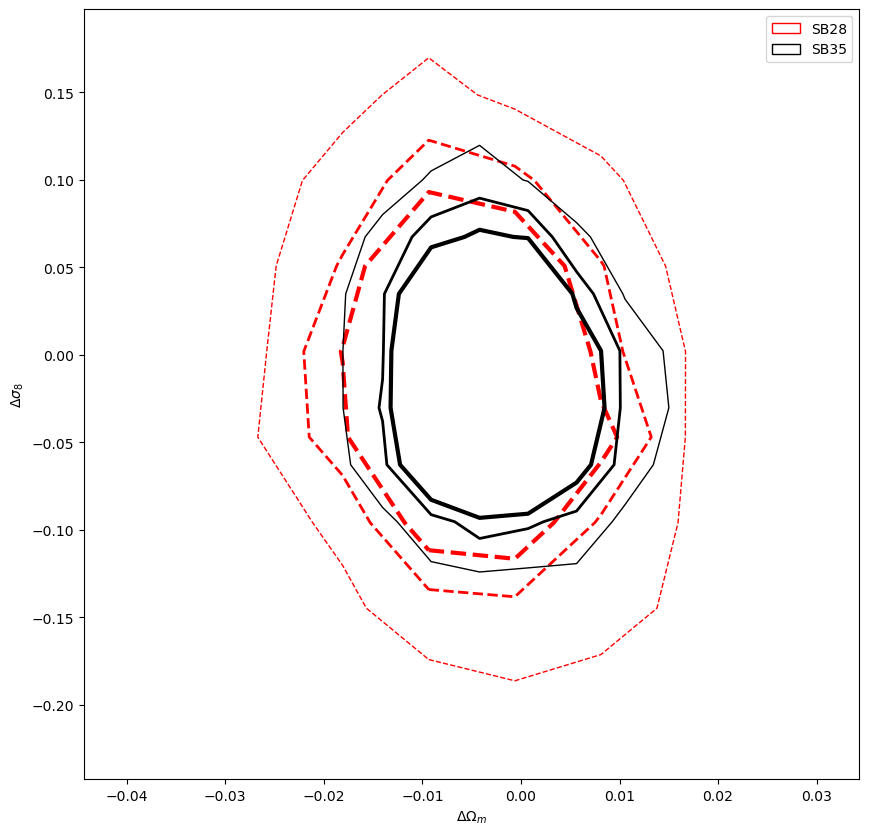

In [53]:
indices = None #range(10) #[0, 1, 2, 40]
from matplotlib.patches import Rectangle


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs = np.array(axs).reshape(-1)
plot_per_simulation(axs[0], data28, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB28", c='r',label="SB28",ls="--")
plot_per_simulation(axs[0], data35, max_plots=6, chunk_size=30,num_samples=200, title="train on SB35 / test on SB35", c='k',label="SB35")
# Create proxy artists matching contour styles
proxy1 = Rectangle((0, 0), 1, 1, edgecolor='red', facecolor='none', linestyle='-')
proxy2 = Rectangle((0, 0), 1, 1, edgecolor='k', facecolor='none', linestyle='-')

# Add legend with those proxies
axs[0].legend([proxy1, proxy2], ['SB28', 'SB35'], title='')
axs[0].set_ylabel("$\Delta \sigma_8$")
axs[0].set_xlabel("$\Delta \Omega_m$")

# PLOT Om color coded

In [6]:
def get_predictions(model, val_loader, max_plots=6, device='cuda'):
    model.eval()
    predictions = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6f}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

    
def get_predictions2(model, model1, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs1 = model1(inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
    predictions = np.c_[predictions,predictions1]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
    #truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]


    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]


def plot_per_simulation(data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs = np.array(axs).reshape(-1)

    axs[0].scatter(truths[:,0],truths[:,0], c="k")
    axs[0].scatter(truths[:,1],truths[:,1], c="r")

    """
    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x    = true[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
        else:
            x    = true
            y    = mean
            yerr = std
        
        bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        bias_of_mean =  np.mean(x - y)
        std_of_each = np.std(truths[:, i] - predictions[:, i])
        mean_std = np.mean(yerr)
        textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=2,        # size of the markers
                        capsize=2,           # length of the error bar caps
                        elinewidth=1.,      # width of the error bar lines
                        markeredgewidth=.5,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')
        # overplot your dots with individual colors
        if sample_indices is not None:
            axs[i].scatter(x, y,
                c=c,
                cmap='viridis',
                s=16,           # marker size
                edgecolor='none',
                zorder=10)  # optional edge
        else:
            axs[i].scatter(x, y,
                s=4,           # marker size
                c="k",
                edgecolor='none',
                zorder=10)  # optional 
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
                    # Text to show
        # Place text in bottom right corner
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )
        axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()
    """
    return 

def residual(data, data_cutout, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None):
    truths_cutout, predictions_cutout, plot_dims_cutout = data_cutout
    truths, predictions, plot_dims = data

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4),
                            gridspec_kw={'wspace': 0.4,  # horizontal space between plots (fraction of subplot width)
                                        'hspace': 0.3})
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]

        array_chunk = predictions_cutout.reshape(-1,chunk_size,plot_dims)
        mean_cutout = array_chunk.mean(axis=1)
        std_cutout  = array_chunk.std(axis=1)
        true_cutout = truths_cutout[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x_cutout    = true_cutout[sample_indices, i]
            y_cutout    = mean_cutout[sample_indices,i]
            yerr_cutout = std_cutout[sample_indices,i]
            x    = true_cutout[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x_cutout    = true_cutout[:num_samples, i]
            y_cutout    = mean_cutout[:num_samples,i]
            yerr_cutout = std_cutout[:num_samples,i]
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
            c    = range(num_samples)
        else:
            x_cutout    = true_cutout
            y_cutout    = mean_cutout
            yerr_cutout = std_cutout
            x    = true
            y    = mean
            yerr = std
            c    = range(len(std))
            

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        """
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=4,        # size of the markers
                        capsize=4,           # length of the error bar caps
                        elinewidth=1.5,      # width of the error bar lines
                        markeredgewidth=1,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')"""
        # overplot your dots with individual colors
        axs[i].scatter(x, y-y_cutout,
            c=c,
            cmap='viridis',
            s=16,           # marker size
            edgecolor='none',
            zorder=10)  # optional edge
        """axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal')"""
        axs[i].axhline(y=0,c='r', ls="--", lw=2)
        axs[i].set_title(f"Target {i}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("SB35 - SB35_cutout")
        axs[i].legend()
        axs[i].grid(True)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 

In [4]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

29

In [13]:
individual = False
_dataSB28, _labelsSB28, _minmaxSB28 = loadCAMELS(field="Mtot",box="SB28", normalization=False, individual=individual)
_dataSB35, _labelsSB35, _minmaxSB35 = loadCAMELS(field="Mtot",box="SB35", normalization=False, individual=individual)
labelsSB28 = torch.tensor(_labelsSB28[:,:2], dtype=dtype)
labelsSB35 = torch.tensor(_labelsSB35[:,:2], dtype=dtype)

In [14]:
linear = False
batch_size=32

dataSB28_norm = np.log10(_dataSB28)
if linear:
  dataSB28_norm_max, dataSB28_norm_min = dataSB28_norm.max(), dataSB28_norm.min()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB28_norm_mean, dataSB28_norm_std =\
      dataSB28_norm.mean(axis=(1, 2), keepdims=True), dataSB28_norm.std(axis=(1, 2), keepdims=True)
  else:
    dataSB28_norm_mean, dataSB28_norm_std = dataSB28_norm.mean(), dataSB28_norm.std()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_mean)/dataSB28_norm_std


#dataSB35_cutout = np.r_[_dataSB35[:,:256,:256],_dataSB35[:,:256,256:]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,:256]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,256:]]
dataSB35_cutout = _dataSB35[:,:256,:256]
dataSB35_cutout_norm = np.log10(dataSB35_cutout)
#dataSB35_cutout_norm = np.log10(_dataSB35_cutout[:,:256,:256])
if linear:
  dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB35_cutout_norm_mean, dataSB35_cutout_norm_std =\
      dataSB35_cutout_norm.mean(axis=(1, 2), keepdims=True), dataSB35_cutout_norm.std(axis=(1, 2), keepdims=True)
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB35_cutout_norm_mean)/dataSB35_cutout_norm_std
  else:
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_mean)/dataSB28_norm_std


monopole28        = _dataSB28.mean(axis=(1,2))
monopole35_cutout = dataSB35_cutout.mean(axis=(1,2))

dataSB35_cutout = torch.tensor(dataSB35_cutout_norm,dtype=dtype)
_, val_setSB35_cutout, _, mono35_cutout_val = split_expanded_dataset(dataSB35_cutout, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True, monopole=monopole35_cutout)
val_loaderSB35_cutout = DataLoader(val_setSB35_cutout, batch_size=batch_size, shuffle=False)

dataSB28 = torch.tensor(dataSB28_norm,dtype=dtype)
_, val_setSB28, _, mono28_val = split_expanded_dataset(dataSB28, labelsSB28, chunk_size=15, val_ratio=0.2, shuffle=True, monopole=monopole28)
val_loaderSB28 = DataLoader(val_setSB28, batch_size=batch_size, shuffle=False)

### SB28

In [25]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *
output_dim = 1#labelsSB28.shape[1]

model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model.to(device)
model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)

model.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_om_best.pt"))
model1.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_sig_best.pt"))
#model2.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_om_best.pt"))
#model3.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_sig_best.pt"))
#model4.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_om_best.pt"))
#model5.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_sig_best.pt"))

data28        = get_predictions2(model, model1, val_loaderSB28, _minmaxSB28, device=device)
data35_cutout = get_predictions2(model, model1, val_loaderSB35_cutout, _minmaxSB28, device=device)
#data35        = get_predictions2(model2, model3, val_loaderSB35, _minmaxSB35, device=device)
#data35_cutout2 = get_predictions2(model4, model5, val_loaderSB35_cutout2, _minmaxSB35, device=device)
#data28_cutout2 = get_predictions2(model4, model5, val_loaderSB28, _minmaxSB35, device=device)


Validation MSE (average over 2 targets): 2.386826e-03
Validation MSE (average over 2 targets): 2.485140e-03


In [7]:
def plot_with_monopole(data, monopole, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x    = true[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
        else:
            x    = true
            y    = mean
            yerr = std
        
        bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        bias_of_mean =  np.mean(x - y)
        std_of_each = np.std(truths[:, i] - predictions[:, i])
        mean_std = np.mean(yerr)
        textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        sc = axs[i].scatter(truths[:, i], predictions[:, i], alpha=1.0, edgecolors='none', c=np.log10(monopole),s=2, vmin=10.9, vmax=12.2,
                            cmap="gist_rainbow")#"hsv")
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
                    # Text to show
        # Place text in bottom right corner
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )
        axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)
    cbar = fig.colorbar(sc, ax=axs[1]) 
    cbar.set_label('log(Mean Density Per Slice)')#, rotation=270, labelpad=15)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 

In [11]:
indices = None #range(10) #[0, 1, 2, 40]

if indices is None:
  plot_with_monopole(data28, mono28_val, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB28")
  plt.savefig("sb28_monopole.png", dpi=100, bbox_inches="tight")
  plot_with_monopole(data35_cutout, mono35_cutout_val, max_plots=6, chunk_size=30,num_samples=200, title="train on SB28 / test on SB35 cutout")
  plt.savefig("sb35_monopole.png", dpi=100, bbox_inches="tight")
else:
  plot_per_simulation(data28, max_plots=6, chunk_size=15,sample_indices=indices)
  plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,sample_indices=indices)
#plt.savefig("train_on_SB28_test_on_both.png")

NameError: name 'plot_with_monopole' is not defined

### SB35 cutout

In [2]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

29

In [3]:
individual = False
_dataSB28, _labelsSB28, _minmaxSB28 = loadCAMELS(field="Mtot",box="SB28", normalization=False, individual=individual)
_dataSB35, _labelsSB35, _minmaxSB35 = loadCAMELS(field="Mtot",box="SB35", normalization=False, individual=individual)
labelsSB28 = torch.tensor(_labelsSB28[:,:2], dtype=dtype)
labelsSB35 = torch.tensor(_labelsSB35[:,:2], dtype=dtype)

In [4]:
linear = False
batch_size=32

_dataSB35_cutout, _labelsSB35_cutout, _ = loadCAMELS(field="Mtot",box="SB35",normalization=True,
                                          linear=False, buffer=0.3, individual=individual)
arr = np.arange(_dataSB35_cutout.shape[0])
step = 10
length = 5

# compute all start‐indices
starts = np.arange(0, len(arr)-length+1, step)   # [  0,  30,  60, …]
# build a 2D index array of shape (n_chunks, length)
idx = starts[:,None] + np.arange(length)   
idx = idx.flatten()

monopole35_cutout = _dataSB35[idx,:256,:256].mean(axis=(1,2))
dataSB35_cutout = torch.tensor(_dataSB35_cutout[idx,:256,:256],dtype=dtype).to(device)
_, val_set, _, mono35_cutout_val  = split_expanded_dataset(dataSB35_cutout, labelsSB35, chunk_size=15, val_ratio=0.2, monopole=monopole35_cutout)
val_loaderSB35_cutout  = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

dataSB35_norm = np.log10(_dataSB35)
dataSB35_norm_mean, dataSB35_norm_std = dataSB35_norm.mean(), dataSB35_norm.std()
#dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB35_norm_mean)/dataSB35_norm_std


dataSB28_norm = np.log10(_dataSB28)
dataSB28_norm = (dataSB28_norm -  dataSB35_norm_mean)/dataSB35_norm_std

#dataSB35_cutout = np.r_[_dataSB35[:,:256,:256],_dataSB35[:,:256,256:]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,:256]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,256:]]

monopole28        = _dataSB28.mean(axis=(1,2))

dataSB28 = torch.tensor(dataSB28_norm,dtype=dtype)
_, val_setSB28, _, mono28_val = split_expanded_dataset(dataSB28, labelsSB28, chunk_size=15, val_ratio=0.2, shuffle=True, monopole=monopole28)
val_loaderSB28 = DataLoader(val_setSB28, batch_size=batch_size, shuffle=False)

In [8]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *
output_dim = 1#labelsSB28.shape[1]

model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model.to(device)
model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)

#model.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_om_best.pt"))
#model1.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_sig_best.pt"))
#model2.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_om_best.pt"))
#model3.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_sig_best.pt"))
model.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_om_best.pt"))
model1.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_sig_best.pt"))

data28        = get_predictions2(model, model1, val_loaderSB28, _minmaxSB35, device=device)
data35_cutout = get_predictions2(model, model1, val_loaderSB35_cutout, _minmaxSB35, device=device)
#data35        = get_predictions2(model2, model3, val_loaderSB35, _minmaxSB35, device=device)
#data35_cutout2 = get_predictions2(model4, model5, val_loaderSB35_cutout2, _minmaxSB35, device=device)
#data28_cutout2 = get_predictions2(model4, model5, val_loaderSB28, _minmaxSB35, device=device)


Validation MSE (average over 2 targets): 3.191240e-03
Validation MSE (average over 2 targets): 2.370944e-03


In [9]:
def plot_with_monopole(data, monopole, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x    = true[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
        else:
            x    = true
            y    = mean
            yerr = std
        
        bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        bias_of_mean =  np.mean(x - y)
        std_of_each = np.std(truths[:, i] - predictions[:, i])
        mean_std = np.mean(yerr)
        textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        sc = axs[i].scatter(truths[:, i], predictions[:, i], alpha=1.0, edgecolors='none', c=np.log10(monopole),s=2, vmin=10.9, vmax=12.2,
                            cmap="gist_rainbow")#"hsv")
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
                    # Text to show
        # Place text in bottom right corner
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )
        axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)
    cbar = fig.colorbar(sc, ax=axs[1]) 
    cbar.set_label('log(Mean Density Per Slice)')#, rotation=270, labelpad=15)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 

Validation MSE (average over 2 targets): 3.191240e-03


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Validation MSE (average over 2 targets): 2.370944e-03


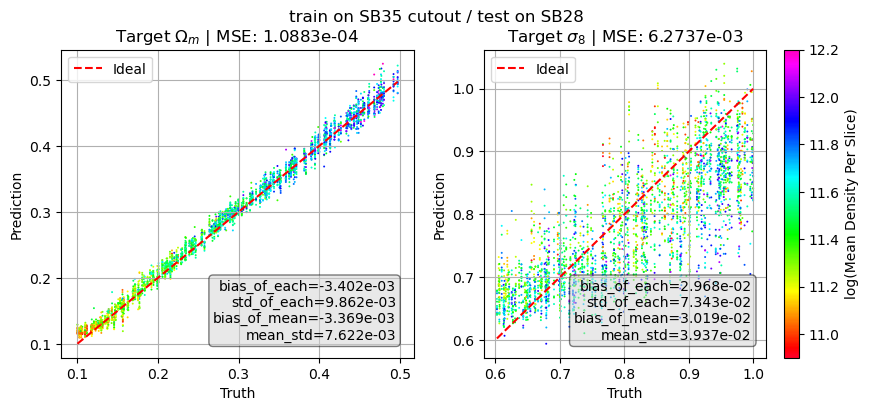

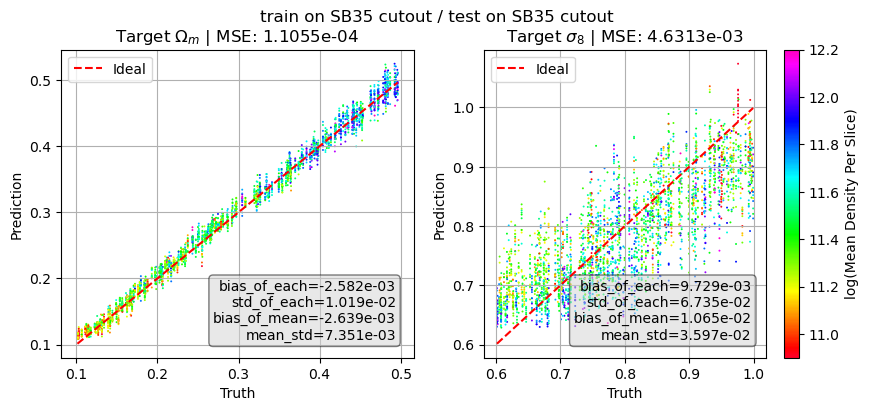

In [10]:
indices = None #range(10) #[0, 1, 2, 40]

if indices is None:
  plot_with_monopole(data28, mono28_val, max_plots=6, chunk_size=15,num_samples=200, title="train on SB35 cutout / test on SB28")
  plt.savefig("sb28_monopole_cutout.png", dpi=100, bbox_inches="tight")
  plot_with_monopole(data35_cutout, mono35_cutout_val, max_plots=6, chunk_size=15,num_samples=200, title="train on SB35 cutout / test on SB35 cutout")
  plt.savefig("sb35_monopole_cutout.png", dpi=100, bbox_inches="tight")
else:
  plot_per_simulation(data28, max_plots=6, chunk_size=15,sample_indices=indices)
  plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,sample_indices=indices)
#plt.savefig("sb35_monopole_cutout.png", dpi=100, bbox_inches="tight")

In [108]:
def plot_with_diff(data, monopole, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
    mono_chunk = monopole.reshape(-1,chunk_size)
    mono_mean = mono_chunk.mean(axis=1)
    mono_diff = mono_mean[:].reshape(-1,1) - mono_chunk[:,:]
    #mono_diff = np.log10(mono_diff)
    #mean = array_chunk.mean(axis=1)
    true = truths[::chunk_size,:]

    for i in range(plot_dims):
        diff = true[:,i].reshape(-1,1) - array_chunk[:,:,i]
        correlation_matrix = np.corrcoef(diff, mono_diff)
        corr_per_row = np.array([
            np.corrcoef(diff[i], mono_diff[i])[0, 1]
            for i in range(diff.shape[0])
        ])
        if sample_indices is not None:
            x    = true[sample_indices, i]
            #y    = ratio[sample_indices]
        elif num_samples is not None:
            x    = true[:num_samples, i]
            #y    = ratio[:num_samples]
        else:
            x    = truths[:,i]
            #y    = ratio
        
        #print(x.shape, corr_per_row.shape)
        #bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        #bias_of_mean =  np.mean(x - y)
        #std_of_each = np.std(truths[:, i] - predictions[:, i])
        #mean_std = np.mean(yerr)
        #textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        #sc = axs[i].scatter(x, y, alpha=1.0, edgecolors='none',
                            #c=np.log10(monopole),s=2, vmin=10.9, vmax=12.2, cmap="gist_rainbow")#"hsv")
        #sc = axs[i].scatter(mono_diff, diff, alpha=1.0, edgecolors='none',
        #                    c=np.log10(monopole),s=2, vmin=10.9, vmax=12.2, cmap="gist_rainbow")#"hsv")
        sc = axs[i].scatter(true[:,i], corr_per_row, alpha=1.0, edgecolors='none')
                            #c=np.log10(monopole),s=2, vmin=10.9, vmax=12.2, cmap="gist_rainbow")#"hsv")
        """
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
        """
                    # Text to show
        # Place text in bottom right corner
        """
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )"""
        #axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_title(f"Target {target_name[i]}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Correlation")
        axs[i].legend()
        axs[i].grid(True)
        #axs[i].set_yscale('log')
        axs[i].set_ylim((0.0,1.0))
    fig.suptitle(title)
    #cbar = fig.colorbar(sc, ax=axs[1]) 
    #cbar.set_label('log(Mean Density Per Slice)')#, rotation=270, labelpad=15)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Validation MSE (average over 2 targets): 2.386826e-03
Validation MSE (average over 2 targets): 2.485140e-03


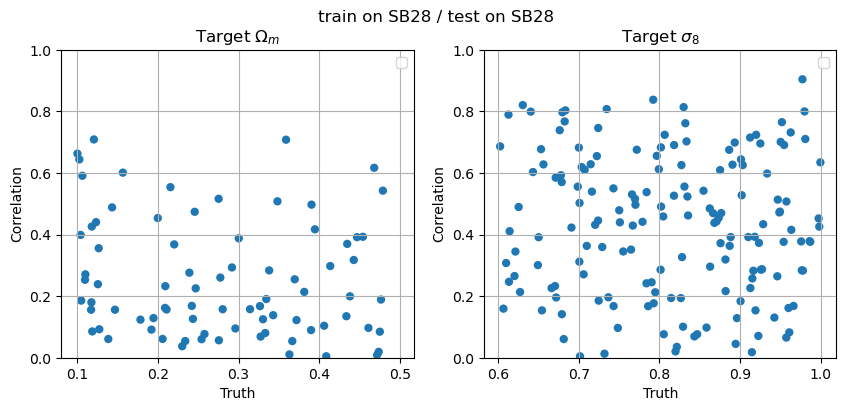

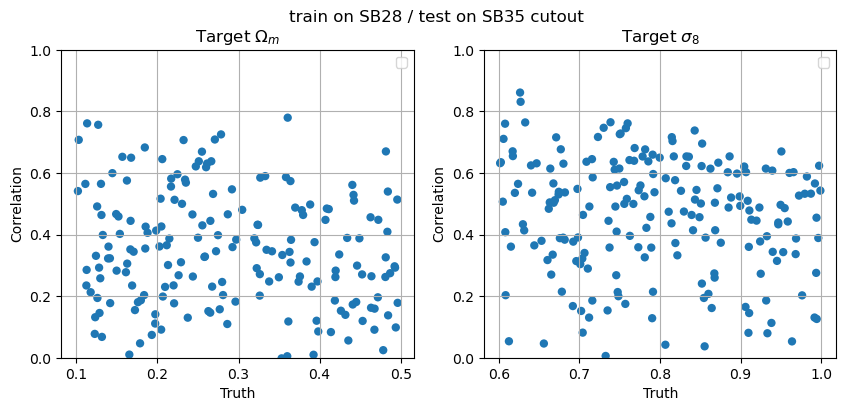

In [109]:
indices = None #range(10) #[0, 1, 2, 40]

if indices is None:
  #plot_with_diff(data28, mono28_val, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB28")
  plot_with_diff(data28, mono28_val, max_plots=6, chunk_size=15, title="train on SB28 / test on SB28")
  plot_with_diff(data35_cutout, mono35_cutout_val, max_plots=6, chunk_size=30, title="train on SB28 / test on SB35 cutout")
else:
  plot_per_simulation(data28, max_plots=6, chunk_size=15,sample_indices=indices)
  plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,sample_indices=indices)
#plt.savefig("train_on_SB28_test_on_both.png")

# Plot 5 Cosmo

### 2D Plot

In [12]:
def get_predictions(model, val_loader, max_plots=6, device='cuda'):
    model.eval()
    predictions = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6f}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

    
def get_predictions2(model, model1, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs1 = model1(inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
    predictions = np.c_[predictions,predictions1]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
    #truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]


    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

   
def get_predictions3(model, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    predictions = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:5,1]-minmax[:5,0]) + minmax[:5,0]
    #truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]


    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

def plot_per_simulation(data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs = np.array(axs).reshape(-1)

    axs[0].scatter(truths[:,0],truths[:,0], c="k")
    axs[0].scatter(truths[:,1],truths[:,1], c="r")

    """
    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x    = true[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
        else:
            x    = true
            y    = mean
            yerr = std
        
        bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        bias_of_mean =  np.mean(x - y)
        std_of_each = np.std(truths[:, i] - predictions[:, i])
        mean_std = np.mean(yerr)
        textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=2,        # size of the markers
                        capsize=2,           # length of the error bar caps
                        elinewidth=1.,      # width of the error bar lines
                        markeredgewidth=.5,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')
        # overplot your dots with individual colors
        if sample_indices is not None:
            axs[i].scatter(x, y,
                c=c,
                cmap='viridis',
                s=16,           # marker size
                edgecolor='none',
                zorder=10)  # optional edge
        else:
            axs[i].scatter(x, y,
                s=4,           # marker size
                c="k",
                edgecolor='none',
                zorder=10)  # optional 
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
                    # Text to show
        # Place text in bottom right corner
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )
        axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()
    """
    return 

def residual(data, data_cutout, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None):
    truths_cutout, predictions_cutout, plot_dims_cutout = data_cutout
    truths, predictions, plot_dims = data

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4),
                            gridspec_kw={'wspace': 0.4,  # horizontal space between plots (fraction of subplot width)
                                        'hspace': 0.3})
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]

        array_chunk = predictions_cutout.reshape(-1,chunk_size,plot_dims)
        mean_cutout = array_chunk.mean(axis=1)
        std_cutout  = array_chunk.std(axis=1)
        true_cutout = truths_cutout[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x_cutout    = true_cutout[sample_indices, i]
            y_cutout    = mean_cutout[sample_indices,i]
            yerr_cutout = std_cutout[sample_indices,i]
            x    = true_cutout[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x_cutout    = true_cutout[:num_samples, i]
            y_cutout    = mean_cutout[:num_samples,i]
            yerr_cutout = std_cutout[:num_samples,i]
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
            c    = range(num_samples)
        else:
            x_cutout    = true_cutout
            y_cutout    = mean_cutout
            yerr_cutout = std_cutout
            x    = true
            y    = mean
            yerr = std
            c    = range(len(std))
            

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        """
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=4,        # size of the markers
                        capsize=4,           # length of the error bar caps
                        elinewidth=1.5,      # width of the error bar lines
                        markeredgewidth=1,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')"""
        # overplot your dots with individual colors
        axs[i].scatter(x, y-y_cutout,
            c=c,
            cmap='viridis',
            s=16,           # marker size
            edgecolor='none',
            zorder=10)  # optional edge
        """axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal')"""
        axs[i].axhline(y=0,c='r', ls="--", lw=2)
        axs[i].set_title(f"Target {i}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("SB35 - SB35_cutout")
        axs[i].legend()
        axs[i].grid(True)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 

### trained separately

In [14]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *
output_dim = 5#labelsSB28.shape[1]





model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model.to(device)
#model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
#model1.to(device)
model2 = ConventionalCNN(input_shape=(512,512), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
#model3 = ConventionalCNN(input_shape=(512,512), output_shape=output_dim, H=16, output_positive=True)
#model3.to(device)
#model4 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
#model4.to(device)
#model5 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
#model5.to(device)

model.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_5cosmo_best.pt"))
#model1.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_sig_best.pt"))
model2.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_5cosmo_best.pt"))
#model3.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_sig_best.pt"))
#model4.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_om_best.pt"))
#model5.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_sig_best.pt"))

data28        = get_predictions3(model, val_loaderSB28, _minmaxSB28, device=device)
#data35_cutout = get_predictions2(model, model1, val_loaderSB35_cutout, _minmaxSB28, device=device)
data35        = get_predictions3(model2, val_loaderSB35, _minmaxSB35, device=device)
#data35_cutout2 = get_predictions2(model4, model5, val_loaderSB35_cutout2, _minmaxSB35, device=device)
#data28_cutout2 = get_predictions2(model4, model5, val_loaderSB28, _minmaxSB35, device=device)


ValueError: operands could not be broadcast together with shapes (3060,5) (3060,2) 

In [ ]:
def plot_per_simulation(ax, data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title="",c='k', label="",ls="-"):
    truths, predictions, plot_dims = data

    #print(truths.shape, predictions.shape)
    array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
    mean = array_chunk.mean(axis=1)
    std  = array_chunk.std(axis=1)
    true = truths[::chunk_size,:]

    diff = truths-predictions
    #ax.scatter(true[:,0],true[:,1], c="k")
    #ax.scatter(mean[:,0],mean[:,1], c="r")

    # Compute 2D histogram
    counts, xedges, yedges = np.histogram2d(diff[:,0], diff[:,1], bins=10)

    # Plot contours
    cs = ax.contour(xedges[:-1], yedges[:-1], counts.T,
                    levels=[20, 60, 100],
                    linewidths=[1, 2, 3],colors=c, label=label, linestyles=ls)

    #ax.scatter(diff[:,0],diff[:,1], c=c)

    #ax.scatter(true[:,0]-mean[:,0],true[:,1]-mean[:,1], c=c)
    #ax.scatter(std[:,0],std[:,1], c=c)
    return 

/tmp/ipykernel_120628/4083217204.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax.contour(xedges[:-1], yedges[:-1], counts.T,


Text(0.5, 0, '$\\Delta \\Omega_m$')

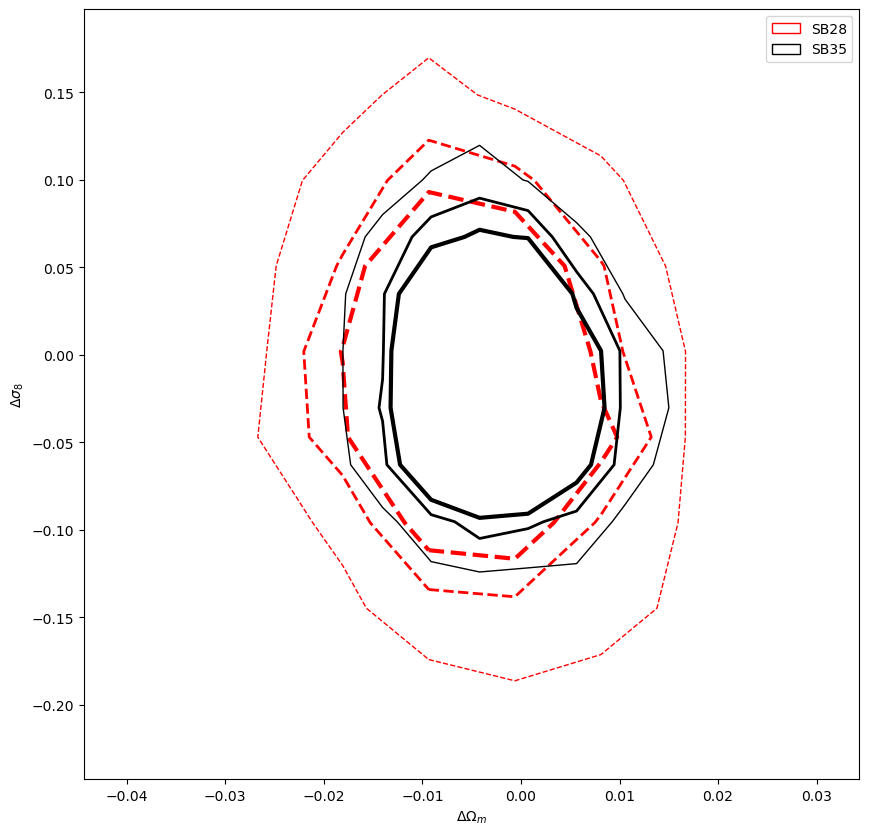

In [ ]:
indices = None #range(10) #[0, 1, 2, 40]
from matplotlib.patches import Rectangle


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs = np.array(axs).reshape(-1)
plot_per_simulation(axs[0], data28, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB28", c='r',label="SB28",ls="--")
plot_per_simulation(axs[0], data35, max_plots=6, chunk_size=30,num_samples=200, title="train on SB35 / test on SB35", c='k',label="SB35")
# Create proxy artists matching contour styles
proxy1 = Rectangle((0, 0), 1, 1, edgecolor='red', facecolor='none', linestyle='-')
proxy2 = Rectangle((0, 0), 1, 1, edgecolor='k', facecolor='none', linestyle='-')

# Add legend with those proxies
axs[0].legend([proxy1, proxy2], ['SB28', 'SB35'], title='')
axs[0].set_ylabel("$\Delta \sigma_8$")
axs[0].set_xlabel("$\Delta \Omega_m$")